In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
import statsmodels.formula.api as smf
from bson import ObjectId
from pymongo import MongoClient

In [297]:
import matplotlib as mpl
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
client = MongoClient('127.0.0.1', 27017)
db = client.moniter_crowdfunding
db.authenticate(name="worker", password="hard", mechanism="SCRAM-SHA-1")

True

In [90]:
db.list_collection_names()

['projects',
 'success_projects',
 'founders',
 'failure_projects',
 'front_page',
 'companies']

In [3]:
project = db.projects
s_project = db.success_projects
f_project = db.failure_projects
front_page = db.front_page
company = db.companies

In [4]:
num_Psucc = s_project.count_documents({'状态': '项目成功'})
num_Csucc = project.count_documents({'状态': '众筹成功'})
num_Cing = project.count_documents({'状态': '众筹中'})
num_Pheat = project.count_documents({'状态': '预热中'})
num_Fproj = f_project.count_documents({})
print(f'项目成功:{num_Psucc}', f'众筹成功:{num_Csucc}', 
      f'众筹中:{num_Cing}', f'预热中:{num_Pheat}', f'项目失败:{num_Fproj}', sep='\t')

项目成功:4160	众筹成功:133	众筹中:95	预热中:10	项目失败:3040


## 0. 什么是羊群效应？

在观察到周围的大量同伴做出某个决策之后，随之做出相同的决策。从时序上来看，观察和决策两个动作之间具有先后次序，观察在前，决策在后。因此，如果需要检验是否存在羊群效用，应该分析下一阶段未决策群体的决策是否受到当前已采纳群体数量的影响。

自变量: 

众筹融资时限、项目类别、评论数量、早期关注者数量、平台展示时长、资助者数量、平台展示时长、预热时长、竞争强度、发起人经验、发起人是否为法人

## 2. 项目数据转换

### 2.1 获取众筹期间项目在主页各位置的展示时间

以项目编号为键，记录各项目记录在主页中出现的时间和位置。
> 项目在列表中，因此只要将列表中的值反转即可得到项目的位置和时间。

然后，找出对应每个项目出现在主页上的时间。

In [5]:
top_keys = ['轮播', '即将上架', 'demostr_proj', '即将结束', '热门推荐', '最新上架']

In [301]:
front_df.columns

Index(['轮播_left', '即将上架', 'demostr_proj_健康出行_左上大图', 'demostr_proj_健康出行_其它图',
       'demostr_proj_生活美学_左上大图', 'demostr_proj_生活美学_其它图',
       'demostr_proj_文化艺术_左上大图', 'demostr_proj_文化艺术_其它图',
       'demostr_proj_惠民扶贫_左上大图', 'demostr_proj_惠民扶贫_其它图',
       'demostr_proj_美食市集_左上大图', 'demostr_proj_美食市集_其它图',
       'demostr_proj_新奇酷玩_左上大图', 'demostr_proj_新奇酷玩_其它图', '即将结束', '热门推荐',
       '最新上架', '轮播_rt', '轮播_rbl', '轮播_rbr'],
      dtype='object')

In [6]:
keys = []
f_page = front_page.find_one()
for key1 in f_page:
    if key1 in ('即将上架', '最新上架', '热门推荐', '即将结束'):
        keys.append(key1)
    elif key1 == '轮播':
        for key2 in f_page[key1]:
            keys.append(key1 + '_' + key2)
    elif key1 == 'demostr_proj':
        for key2 in f_page[key1]:
            for key3 in f_page[key1][key2]:
                keys.append(key1 + '_' + key2 + '_' + key3)     

- 获取主页的版块信息作为键

In [7]:
new_dict = {}
for f_page in front_page.find():
#     f_page = front_page.find_one({})
    _id = f_page["_id"]  # _id 为 ObjectId
    for key1 in f_page:
        if key1 in ('即将上架', '最新上架', '热门推荐', '即将结束'):
            for p_id in f_page[key1]:
                if p_id in new_dict:
                    new_dict[p_id].append((key1, _id))
                else:
                    new_dict[p_id] = [(key1, _id)]
                    
        elif key1 == '轮播':
            for key2 in f_page[key1]:
                for p_id in f_page[key1][key2]:
                    if p_id in new_dict:
                        new_dict[p_id].append((key1 + '_' + key2, _id))
                    else:
                        new_dict[p_id] = [(key1 + '_' + key2, _id)]
                        
        elif key1 == 'demostr_proj':
            for key2 in f_page[key1]:
                for key3 in f_page[key1][key2]:
                    for p_id in f_page[key1][key2][key3]:
                        if p_id in new_dict:
                            new_dict[p_id].append((key1 + '_' + key2 + '_' + key3, _id))
                        else:
                            new_dict[p_id] = [(key1 + '_' + key2 + '_' + key3, _id)]

- 转换为以项目编号进行组织
```python
>>> item = s_project.find_one({"_id": "1818031176"}, projection={'项目动态信息': False, '各档动态信息': False, "评论": False})
>>> item['状态变换时间2-3'] - item['状态变换时间1-2']
datetime.timedelta(days=80, microseconds=601000)
```

In [8]:
res_dict = {'p_id': [], **{key: [] for key in keys}}
for p_id in new_dict:
    res_dict['p_id'].append(p_id)
    a = new_dict[p_id]
    new_a = [(x[0], x[1].generation_time.timestamp()) for x in a]   # 将ObjectId转换为时间戳
    merge_a = {}
    for u in new_a:  # 将时间集中写到一个列表中
        merge_a[u[0]] = merge_a.get(u[0], []) + [u[1]]

    demo_a = {key: 0 for key in keys}  # 初始化各版块的时间为0
    for key in merge_a:  # 获取项目在主页各版块的展示时长
        t_list = sorted(merge_a[key])  # 排好序的时间列表
        item = s_project.find_one({"_id": p_id}, 
                                  projection={'状态变换时间0-1': True, '状态变换时间1-2': True, '状态变换时间2-3': True, 
                                              '状态变换时间3-4': True, '众筹期限': True})
        if item:  # 如果在成功项目中有结果
            t0 = item["状态变换时间0-1"].timestamp()  # 观察开始时间
            t1 = item["状态变换时间2-3"].timestamp()  # 众筹成功时间
        else:  # 找不到则到失败项目集合中继续查找
            item = f_project.find_one({"_id": p_id}, 
                                      projection={'状态变换时间0-1': True, '状态变换时间1-2': True, 
                                                  '状态变换时间1-3': True, '状态变换时间2-3': True, 
                                                  '状态变换时间3-4': True, '众筹期限': True})
            if item:  # 如果不是直接转移的失败项目，则继续查找
                t0 = item["状态变换时间0-1"].timestamp()
                t1 = item.get("状态变换时间1-3", 
                              item.get("状态变换时间2-3", 
                                       item["状态变换时间0-1"] + datetime.timedelta(days=item['众筹期限']))).timestamp()  # 众筹失败时间
            else:
                item = f_project.find_one({"详细信息._id": p_id},
                                          projection={'详细信息.状态变换时间0-1': True, '详细信息.状态变换时间1-2': True, 
                                                      '详细信息.状态变换时间1-3': True, '详细信息.状态变换时间2-3': True, 
                                                      '详细信息.众筹期限': True})
                if item:  # 如果不是直接转移的失败项目，则继续查找
                    item = item["详细信息"]
                    t0 = item["状态变换时间0-1"].timestamp()
                    t1 = item.get("状态变换时间1-3", 
                                  item.get("状态变换时间2-3", 
                                           item["状态变换时间0-1"] + datetime.timedelta(days=item['众筹期限']))).timestamp()  # 众筹失败时间
                else:  # 实在找不到这个项目
                    t0 = min(t_list)
                    t1 = max(t_list)
        
        start_t = max(t0, min(t_list))
        end_t = min(t1, max(t_list))
        demo_a[key] = (end_t - start_t) / 3600  # 转化为小时

    for key in demo_a:
        res_dict[key].append(demo_a[key])

In [9]:
keys = [x.replace('-', '') for x in keys]  # -在建模时与减少冲突

In [10]:
front_df = pd.DataFrame(res_dict)
front_df.index = front_df["p_id"]
front_df['轮播_rt'] = front_df['轮播_r-t']
front_df['轮播_rbl'] = front_df['轮播_r-b-l']
front_df['轮播_rbr'] = front_df['轮播_r-b-r']
del front_df['轮播_r-t']
del front_df['轮播_r-b-l']
del front_df['轮播_r-b-r']
del front_df["p_id"]
front_df.head()

,轮播_left,即将上架,demostr_proj_健康出行_左上大图,demostr_proj_健康出行_其它图,demostr_proj_生活美学_左上大图,demostr_proj_生活美学_其它图,demostr_proj_文化艺术_左上大图,demostr_proj_文化艺术_其它图,demostr_proj_惠民扶贫_左上大图,demostr_proj_惠民扶贫_其它图,demostr_proj_美食市集_左上大图,demostr_proj_美食市集_其它图,demostr_proj_新奇酷玩_左上大图,demostr_proj_新奇酷玩_其它图,即将结束,热门推荐,最新上架,轮播_rt,轮播_rbl,轮播_rbr
p_id,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,13.818889,0.0,0.0
98692,0.000000,0.0,0.000000,0.0,11.366389,69.819444,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5.923333,0.0,0.0
98954,0.000000,0.0,0.000000,0.0,0.000000,0.000000,117.965556,45.999722,0.0,0.0,0.000000,0.000000,0.0,0.0,6.0,0.0,0.0,101.818611,0.0,0.0
97491,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,21.819167,94.146389,0.0,0.0,0.0,0.0,0.0,117.965556,0.0,0.0
98540,1.919167,0.0,21.999722,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [11]:
front_df[front_df.热门推荐 > 1000].count()

轮播_left                   32
即将上架                      32
demostr_proj_健康出行_左上大图    32
demostr_proj_健康出行_其它图     32
demostr_proj_生活美学_左上大图    32
demostr_proj_生活美学_其它图     32
demostr_proj_文化艺术_左上大图    32
demostr_proj_文化艺术_其它图     32
demostr_proj_惠民扶贫_左上大图    32
demostr_proj_惠民扶贫_其它图     32
demostr_proj_美食市集_左上大图    32
demostr_proj_美食市集_其它图     32
demostr_proj_新奇酷玩_左上大图    32
demostr_proj_新奇酷玩_其它图     32
即将结束                      32
热门推荐                      32
最新上架                      32
轮播_rt                     32
轮播_rbl                    32
轮播_rbr                    32
dtype: int64

In [304]:
front_df[front_df.即将上架>0].describe()

,轮播_left,即将上架,demostr_proj_健康出行_左上大图,demostr_proj_健康出行_其它图,demostr_proj_生活美学_左上大图,demostr_proj_生活美学_其它图,demostr_proj_文化艺术_左上大图,demostr_proj_文化艺术_其它图,demostr_proj_惠民扶贫_左上大图,demostr_proj_惠民扶贫_其它图,demostr_proj_美食市集_左上大图,demostr_proj_美食市集_其它图,demostr_proj_新奇酷玩_左上大图,demostr_proj_新奇酷玩_其它图,即将结束,热门推荐,最新上架,轮播_rt,轮播_rbl,轮播_rbr
count,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.00000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000
mean,14.115087,43.358870,17.806947,49.062527,27.119758,79.623064,16.464845,47.115473,17.572090,52.736384,16.766389,55.301182,23.67273,67.286634,24.142463,22.664630,96.937152,12.989394,10.685689,9.866211
std,89.270881,35.936781,136.109656,294.731646,146.152850,265.996052,108.891632,200.849549,109.592827,200.166797,106.758036,206.310768,133.05288,281.406502,66.387434,128.685681,201.665550,81.494428,68.460532,75.133788
min,0.000000,1.784894,-443.999735,-17.999552,-41.993011,-456.000033,-114.000403,-24.000343,0.000000,0.000000,0.000000,-65.999939,0.00000,-1559.999369,-953.999469,-47.999921,-17.995282,-102.008209,-17.999994,-2046.004456
25%,0.000000,17.998544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,35.999559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,17.999722,0.000000,12.000000,0.000000,0.000000,0.000000
75%,0.000000,60.002088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,47.999722,0.000000,90.000278,0.000000,0.000000,0.000000
max,1680.005556,353.999422,3569.999444,10391.999722,2009.999722,7079.999444,1506.000278,2465.999722,1433.999722,1674.000000,1625.992222,1914.000278,1818.00000,9402.000000,1044.000278,1698.000278,2082.000278,2183.998889,1085.999944,1619.999444


In [222]:
front_df.columns

Index(['轮播_left', '即将上架', 'demostr_proj_健康出行_左上大图', 'demostr_proj_健康出行_其它图',
       'demostr_proj_生活美学_左上大图', 'demostr_proj_生活美学_其它图',
       'demostr_proj_文化艺术_左上大图', 'demostr_proj_文化艺术_其它图',
       'demostr_proj_惠民扶贫_左上大图', 'demostr_proj_惠民扶贫_其它图',
       'demostr_proj_美食市集_左上大图', 'demostr_proj_美食市集_其它图',
       'demostr_proj_新奇酷玩_左上大图', 'demostr_proj_新奇酷玩_其它图', '即将结束', '热门推荐',
       '最新上架', '轮播_rt', '轮播_rbl', '轮播_rbr'],
      dtype='object')

### 2.2 获取由**众筹开始时间**到**完成百分比第1次大于100**范围内的动态数据
> 若失败，则取最后一次监测时间

按照项目更新时间将项目动态信息转换为`pd.DataFrame()`

In [14]:
def to_df(item):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
        
    # 根据更新时间去除重复
    a1 = dyn_info[0]
    records = {'更新时间':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间'] or a2["完成百分比"] != a1["完成百分比"]:  # 有些时候，更新时间相同但是完成百分比不相同
            records['更新时间'].append(a2['更新时间'])
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            a1 = a2

    col_names = ['关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

In [15]:
def getTimeRange(df, start_t):
    x = df[df.index >= start_t]  # 开始众筹至观测结束
    y = x[x.完成百分比.values >= 100]  # 第一次达到众筹金额100%至观测结束
    if len(y) > 1:
        return x[:y.index[1]]  # 开始众筹至第一次达到众筹金额100%
    else:  # 若以非常快的速度完成100%
        return x[:]  # 在最后时刻到达众筹金额100%或众筹失败

获取所有**项目成功项目**的**众筹开始时间**到**完成百分比第1次大于100**的时间间隔

>其中涉及到pandas时间间隔转为秒，有两个关键的函数，首先通过`.to_pytimedelta()`将`pd.Timedelta()`转换为`datetime.datetime()`，然后利用`.total_seconds()`将`datetime.datetime()`转换为时间秒。示例：
```python
>>> pd.Timestamp("2019-3-13 23:58:10").to_pydatetime()
datetime.datetime(2019, 3, 13, 23, 58, 10)
>>> pd.Timestamp("2019-3-13 23:58:10").to_pydatetime().timestamp()
1552492690.0
>>> pd.Timestamp("2012-12-21") - pd.Timestamp("2012-12-1")
Timedelta('20 days 00:00:00')
>>> pd.Timedelta('5:00:00').to_pytimedelta().total_seconds()
18000.0
>>> datetime.timedelta(days=1, hours=1, minutes=1).total_seconds()
90060.0

```

In [18]:
item = s_project.find_one({}, projection={'状态变换时间0-1': True, '状态变换时间1-2': True, '状态变换时间2-3': True, '状态变换时间3-4': True, '众筹期限': True})
t0 = item['状态变换时间0-1'].timestamp()
t1 = item['状态变换时间2-3'].timestamp()
t2 = (item['状态变换时间1-2'] + datetime.timedelta(days=45)).timestamp()

In [21]:
def getStatus(projs):  # 获取
    intv_dict, relative_intv_dict = [], []
    for i, item in enumerate(projs):
        if '详细信息' in item:  # 部分项目失败信息
            item = item['详细信息']
            
        try:
            df = to_df(item)
            try:
                start_t = item['状态变换时间1-2']  # 众筹开始时间
            except KeyError:
                start_t = df.index[0].to_pydatetime()

            try:
                end_t = item['状态变换时间2-3']  # 众筹成功时间
            except KeyError:
                end_t = df.index[-1].to_pydatetime()

            t_df = getTimeRange(df, start_t)  # 开始众筹至第一次达到众筹金额100%
            time_interval = (t_df.index[-1] - t_df.index[0]).to_pytimedelta().total_seconds()  # 总时间，转化为浮点数(秒)
            tot_inteval = (end_t - start_t).total_seconds()  # 计划总时间
            intv_dict.append((item['_id'], time_interval))
            relative_intv_dict.append((item['_id'], time_interval / tot_inteval))
        except IndexError as e:
            print(i, item['_id'], e)
            intv_dict.append((item['_id'], np.nan))  # 说明有问题
            relative_intv_dict.append((item['_id'], np.nan))
        except KeyError as k:
            print(i, item['_id'], k)
            intv_dict.append((item['_id'], np.nan))
            relative_intv_dict.append((item['_id'], np.nan))
            
    df = pd.DataFrame({'绝对时间跨度': [x[1] for x in intv_dict], 
                       '相对时间跨度': [x[1] for x in relative_intv_dict]}, 
                       index = pd.Index([x[0] for x in intv_dict]))
    return df

In [22]:
projs = s_project.find()
df2 = getStatus(projs)

In [23]:
df2.tail()

,绝对时间跨度,相对时间跨度
99942,781599.0,0.181392
99946,2454680.0,0.954190
99964,966836.0,0.371299
99968,1049911.0,0.263673
99981,2180077.0,0.838887


### 2.3 获取项目静态基本信息

In [25]:
oval_columns = ['状态', '众筹期限', '公司名称', '公司地址', '公司工作时间', '公司电话', '发起人名称', 
                '发起人链接', '所属类别', '目标金额', '项目名称', 
                '状态变换时间0-1', '状态变换时间1-2', '状态变换时间2-3', '状态变换时间3-4']

dyn_columns = ['筹集金额', '关注数', '支持者数', '点赞数', '完成百分比']
sts_columns = ['评论数量', '档位数量']

将所有项目的信息转换为`pd.DataFrame`

In [26]:
def proj_info(projs, oval_columns=oval_columns, sts_columns=sts_columns, dyn_columns=dyn_columns):
    '''
    得到一个成功项目集合对应的dataframe
    部分失败项目信息直接转移了failure_projects，而部分项目则保存在文档对应的“详细信息”域中
    '''
    col_names = oval_columns + sts_columns + dyn_columns
    cf_dict = {x:[] for x in col_names}
    idx = []
    for item in projs:
        if '详细信息' in item:  # 处理部分众筹失败项目
            item = item['详细信息']
        
        idx.append(item['_id'])
        for c in oval_columns:
            try:
                cf_dict[c].append(item[c])
            except Exception as e:
                print(item['_id'], e)
                cf_dict[c].append(None)
        try:
            dyn_info = item['项目动态信息'][-1]
            for c in dyn_columns:
                try:
                    cf_dict[c].append(dyn_info[c])
                except Exception as e:
                    print(item['_id'], e)
                    cf_dict[c].append(None)
        except Exception as e:
            print(item['_id'], e)

        try:
            cf_dict['评论数量'].append(item['评论']['总评论数'])
        except Exception as e:
            cf_dict['评论数量'].append(None)
            
        try:
            cf_dict['档位数量'].append(max(len(item['各档基础信息']), 1))  # 有些档位数为1不列出档位信息
        except Exception as e:
            cf_dict['档位数量'].append(1)

    df = pd.DataFrame(cf_dict, index=idx, columns=col_names)
    return df

项目成功信息

In [27]:
projs = s_project.find({'状态':'项目成功'})
df3 = proj_info(projs)
df3['完成百分比'] = df3['完成百分比'] / 100

99138 '状态变换时间1-2'


项目失败信息

In [28]:
f_projs = f_project.find()
df4 = proj_info(f_projs)
df4['完成百分比'] = df4['完成百分比'] / 100

101445 '状态变换时间2-3'
101445 '状态变换时间3-4'
103364 '状态变换时间2-3'
103364 '状态变换时间3-4'
103994 '状态变换时间3-4'
104616 '状态变换时间2-3'
104616 '状态变换时间3-4'
105118 '状态变换时间2-3'
105118 '状态变换时间3-4'
105574 '状态变换时间2-3'
105574 '状态变换时间3-4'
105826 '状态变换时间2-3'
105826 '状态变换时间3-4'
105838 '状态变换时间2-3'
105838 '状态变换时间3-4'
106062 '状态变换时间2-3'
106062 '状态变换时间3-4'
106384 '状态变换时间2-3'
106384 '状态变换时间3-4'
106401 '状态变换时间2-3'
106401 '状态变换时间3-4'
106593 '状态变换时间2-3'
106593 '状态变换时间3-4'
106606 '状态变换时间2-3'
106606 '状态变换时间3-4'
106782 '状态变换时间2-3'
106782 '状态变换时间3-4'
107043 '状态变换时间2-3'
107043 '状态变换时间3-4'
107232 '状态变换时间2-3'
107232 '状态变换时间3-4'
107378 '状态变换时间2-3'
107378 '状态变换时间3-4'
107424 '状态变换时间2-3'
107424 '状态变换时间3-4'
107474 '状态变换时间2-3'
107474 '状态变换时间3-4'
107524 '状态变换时间2-3'
107524 '状态变换时间3-4'
107547 '状态变换时间2-3'
107547 '状态变换时间3-4'
107575 '状态变换时间2-3'
107575 '状态变换时间3-4'
107669 '状态变换时间2-3'
107669 '状态变换时间3-4'
107704 '状态变换时间2-3'
107704 '状态变换时间3-4'
107809 '状态变换时间2-3'
107809 '状态变换时间3-4'
107835 '状态变换时间2-3'
107835 '状态变换时间3-4'
107847 '状态变换时间2-3'
107847 '状态变换

合并项目成功和失败信息

In [29]:
c_df = pd.concat([df3, df4])

In [30]:
c_df.count()

状态           7200
众筹期限         7200
公司名称         7195
公司地址         7195
公司工作时间       7196
公司电话         7196
发起人名称        7200
发起人链接        7200
所属类别         7200
目标金额         7200
项目名称         7200
状态变换时间0-1    7200
状态变换时间1-2    7199
状态变换时间2-3    4738
状态变换时间3-4    4184
评论数量         6974
档位数量         7200
筹集金额         7200
关注数          7200
支持者数         7200
点赞数          7200
完成百分比        7200
dtype: int64

In [146]:
c_df[(c_df.状态 != '项目成功') & (c_df.完成百分比 > 1)][['公司名称', '状态', '关注数', '点赞数', '支持者数', '目标金额','筹集金额','完成百分比']].sort_values(by='完成百分比', ascending=False)

,公司名称,状态,关注数,点赞数,支持者数,目标金额,筹集金额,完成百分比
1836592129,青岛奥费斯科技有限公司,项目未成功,2448,290,1910,5000,120025,24.01
107803,阳高绿色天地科技有限公司,众筹未成功,437,158,1204,20000,305162,15.26
109331,深圳市松鼠视觉传媒有限公司,众筹未成功,624,45,2189,200000,2019978,10.10
109768,深圳市好万家科技有限公司,众筹未成功,253,233,322,100000,1008179,10.08
108718,北京万兔思睿科技有限公司,众筹未成功,8941,7296,2699,200000,937966,9.38
108249,青岛奥费斯科技有限公司,项目未成功,1113,62,735,50000,334988,6.70
1842435244,上海晶合光电科技有限公司,众筹未成功,225,67,166,10000,60656,6.07
107938,福州广诚行贸易有限公司,项目未成功,164,20,318,30000,168457,5.62
104284,北京世纪千里马商贸有限责任公司,众筹未成功,1537,97,3678,200000,1099996,5.50
110091,龙州香茗茶业有限责任公司,众筹未成功,282,73,4000,50000,249511,4.99


<AxesSubplot:ylabel='Frequency'>

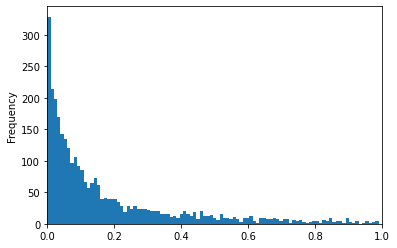

In [136]:
c_df[c_df.完成百分比 < 1].完成百分比.plot.hist(bins=100, xlim=[0, 1])

<AxesSubplot:ylabel='Frequency'>

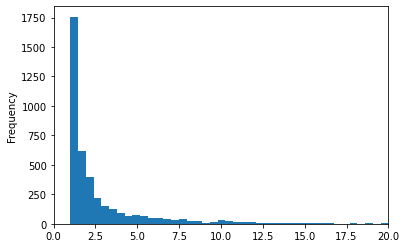

In [185]:
c_df[c_df.完成百分比 >= 1].完成百分比.plot.hist(bins=5000, xlim=[0, 20])

### 2.4 项目发起人的经验

直接经验: 发起项目的数量、类别数量

间接经验：资助项目的数量

In [91]:
company = db.companies

In [154]:
exp_dict = {'项目编号': [], '已发起项目数':[], '已支持项目数': []}
a = 0
for p_id in c_df.index:
    item = company.find_one({"发起项目": p_id})
    if item:
        num_launch = np.sum(np.array([int(x) for x in item["发起项目"]]) < int(p_id))  # 按项目编号计算当前p_id之前发起过的项目数量
        num_support = np.sum(np.array([int(x) for x in item["支持项目"]]) < int(p_id))  # 按项目编号计算当前p_id之前发起过的项目数量
        exp_dict['项目编号'].append(p_id)
        exp_dict['已发起项目数'].append(num_launch)
        exp_dict['已支持项目数'].append(num_support)
    else:
        a += 1

In [173]:
company.find_one({'公司名称': '郑州封之匠电子商务有限公司'})

In [157]:
exp_df = pd.DataFrame(exp_dict, columns=['已发起项目数', '已支持项目数'], index=exp_dict['项目编号'])

In [171]:
exp_df[exp_df.已发起项目数 > 0].describe()

,已发起项目数,已支持项目数
count,1713.000000,1713.000000
mean,2.779918,0.466433
std,1.886070,1.165689
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,4.000000,0.000000
max,7.000000,8.000000


In [174]:
company.count_documents({})

4836

In [167]:
u_df = pd.merge(c_df, exp_df, how="left", left_index=True, right_index=True, sort=True)  # 先合并

In [170]:
u_df[pd.isna(u_df.已发起项目数)][['众筹期限', '公司名称', '目标金额', '已发起项目数', '已支持项目数']]

,众筹期限,公司名称,目标金额,已发起项目数,已支持项目数
100034,45,郑州封之匠电子商务有限公司,30000,NaN,NaN
100081,40,上海宸赞电子有限公司,200000,NaN,NaN
100127,45,味觉方舟（深圳）科技有限公司,30000,NaN,NaN
100162,30,福州广诚行贸易有限公司,30000,NaN,NaN
100163,40,福州广诚行贸易有限公司,30000,NaN,NaN
...,...,...,...,...,...
99693,30,泛音电动工具（太仓）有限公司,200000,NaN,NaN
99848,20,杭州绿宜贸易有限公司,10000,NaN,NaN
99906,45,福建聚融实业有限公司,200000,NaN,NaN
99927,60,阿克苏珍玉果电子商务有限公司,10000,NaN,NaN


In [314]:
company.find_one({'已发起项目数': '107555'})

In [175]:
c_df.loc['107555']

状态                                            项目成功
众筹期限                                            45
公司名称                                 郑州封之匠电子商务有限公司
公司地址               河南郑州市新郑市  人民路168号西亚斯御璟2号楼2-19室。
公司工作时间                             工作日 09:00-18:00
公司电话                                   15617971082
发起人名称                                       华匠左藏总舵
发起人链接        /funderCenter.action?flag=2&id=107555
所属类别                                          文化传承
目标金额                                         10000
项目名称                                华匠左藏x宋隐x吉祥五福建盏
状态变换时间0-1               2018-11-29 00:00:03.231000
状态变换时间1-2               2018-11-30 12:00:03.391000
状态变换时间2-3               2019-01-14 12:00:03.959000
状态变换时间3-4               2019-03-12 06:00:08.543000
评论数量                                            11
档位数量                                             8
筹集金额                                         17423
关注数                                             77
支持者数                           

In [98]:
s_project.find_one({'_id': '101974'}, projection={'状态变换时间0-1': True, '状态变换时间1-2': True, '状态变换时间2-3': True, 
                                                  '状态变换时间3-4': True, '众筹期限': True, '所属类别': True, '状态': True})

{'_id': '101974',
 '状态': '项目成功',
 '状态变换时间0-1': datetime.datetime(2018, 6, 12, 0, 0, 3, 466000),
 '众筹期限': 45,
 '所属类别': '原创设计',
 '状态变换时间1-2': datetime.datetime(2018, 6, 14, 20, 5, 1, 958000),
 '状态变换时间2-3': datetime.datetime(2018, 7, 29, 12, 0, 3, 450000),
 '状态变换时间3-4': datetime.datetime(2018, 8, 17, 9, 56, 18, 553000)}

In [120]:
c_df.columns

Index(['状态', '众筹期限', '公司名称', '公司地址', '公司工作时间', '公司电话', '发起人名称', '发起人链接',
       '所属类别', '目标金额', '项目名称', '状态变换时间0-1', '状态变换时间1-2', '状态变换时间2-3',
       '状态变换时间3-4', '评论数量', '档位数量', '筹集金额', '关注数', '支持者数', '点赞数', '完成百分比'],
      dtype='object')

### 2.5 合并和转换数据

In [31]:
s_df = pd.merge(c_df, df2, how="left", left_index=True, right_index=True, sort=True)  # 先合并

- 处理失败项目的时间跨度

In [32]:
indices = pd.isna(s_df.绝对时间跨度) 
s_df.loc[indices, '绝对时间跨度'] = s_df[indices]['众筹期限'] * 3600 * 24
s_df.loc[indices, '相对时间跨度'] = 1

In [33]:
dt = pd.merge(s_df, front_df, how="left", left_index=True, right_index=True, sort=True)

In [34]:
dt.loc[:, keys] = dt[keys].fillna(0) # 填充未在主页出现的项目为0

- 推荐页面总时长

In [35]:
dt["推荐页面总时长"] = dt[keys].sum(axis=1)

- 在各类别版面上出现的总时间

In [36]:
dt["各类版块总时长"] = dt[['demostr_proj_健康出行_左上大图',
     'demostr_proj_健康出行_其它图',
     'demostr_proj_生活美学_左上大图',
     'demostr_proj_生活美学_其它图',
     'demostr_proj_文化艺术_左上大图',
     'demostr_proj_文化艺术_其它图',
     'demostr_proj_惠民扶贫_左上大图',
     'demostr_proj_惠民扶贫_其它图',
     'demostr_proj_美食市集_左上大图',
     'demostr_proj_美食市集_其它图',
     'demostr_proj_新奇酷玩_左上大图',
     'demostr_proj_新奇酷玩_其它图']].sum(axis=1)  # 各类版面的总呈现时长

- 构建是否出现在对应版面的0-1变量：是否出现可反映平台方对众筹项目前景的认可

In [307]:
dt['is_即将上架'] = dt.即将上架.apply(lambda x: 1 if x > 0 else 0)
dt['is_最新上架'] = dt.最新上架.apply(lambda x: 1 if x > 0 else 0)
dt['is_热门推荐'] = dt.热门推荐.apply(lambda x: 1 if x > 0 else 0)
dt['is_各类版块总时长'] = dt.各类版块总时长.apply(lambda x: 1 if x > 0 else 0)
dt['is_即将结束'] = dt.即将结束.apply(lambda x: 1 if x > 0 else 0)

In [316]:
grouped = dt.groupby("所属类别").size()  # 获取项目数量大于200的类别
grouped[grouped > 200].sort_values(ascending=False).index

Index(['食品', '原创设计', '公益', '文化传承', '智能家居', '健康医疗', '数码周边', '车品', '健康生活',
       '品质家居', '个人护理'],
      dtype='object', name='所属类别')

- 类别dummy变量

数量大于200的类别: `['食品', '原创设计', '公益', '文化传承', '智能家居', '健康医疗', '数码周边', '车品', '健康生活', '品质家居', '个人护理']`
       
得到这些类别对应的筛选标准

In [317]:
cate = dt["所属类别"].map(lambda x: x in ('食品', '原创设计', '公益', '文化传承', '智能家居', 
                                      '健康医疗', '数码周边', '车品', '健康生活', '品质家居', '个人护理'))

In [318]:
cate_dt = dt[cate]  # 数量大于200对应的项目

In [320]:
cate_dt.columns

Index(['状态', '众筹期限', '公司名称', '公司地址', '公司工作时间', '公司电话', '发起人名称', '发起人链接',
       '所属类别', '目标金额', '项目名称', '状态变换时间0-1', '状态变换时间1-2', '状态变换时间2-3',
       '状态变换时间3-4', '评论数量', '档位数量', '筹集金额', '关注数', '支持者数', '点赞数', '完成百分比',
       '绝对时间跨度', '相对时间跨度', '轮播_left', '即将上架', 'demostr_proj_健康出行_左上大图',
       'demostr_proj_健康出行_其它图', 'demostr_proj_生活美学_左上大图',
       'demostr_proj_生活美学_其它图', 'demostr_proj_文化艺术_左上大图',
       'demostr_proj_文化艺术_其它图', 'demostr_proj_惠民扶贫_左上大图',
       'demostr_proj_惠民扶贫_其它图', 'demostr_proj_美食市集_左上大图',
       'demostr_proj_美食市集_其它图', 'demostr_proj_新奇酷玩_左上大图',
       'demostr_proj_新奇酷玩_其它图', '即将结束', '热门推荐', '最新上架', '轮播_rt', '轮播_rbl',
       '轮播_rbr', '推荐页面总时长', '各类版块总时长', 'is_最新上架', 'is_热门推荐', 'is_各类版块总时长',
       'is_即将结束', 'is_即将上架'],
      dtype='object')

In [321]:
dummy = pd.get_dummies(cate_dt['所属类别'], prefix='类别', drop_first=False)  # 转换为one-hot变量

In [322]:
dummy.head()

,类别_个人护理,类别_健康医疗,类别_健康生活,类别_公益,类别_原创设计,类别_品质家居,类别_数码周边,类别_文化传承,类别_智能家居,类别_车品,类别_食品
100006,0,1,0,0,0,0,0,0,0,0,0
100009,0,0,0,0,0,0,0,0,1,0,0
100010,0,0,0,0,1,0,0,0,0,0,0
100016,0,0,0,0,0,1,0,0,0,0,0
100031,0,0,0,0,1,0,0,0,0,0,0


In [323]:
cate_dt = pd.concat([cate_dt, dummy], axis=1)  # 增加dummy变量

In [324]:
col_name = ['关注数', '支持者数', '评论数量', '档位数量', '绝对时间跨度', '相对时间跨度', '完成百分比', 
            '推荐页面总时长', *demo_cols]
cate_dt[col_name].corr()

,关注数,支持者数,评论数量,档位数量,绝对时间跨度,相对时间跨度,完成百分比,推荐页面总时长,即将上架,最新上架,热门推荐,各类版块总时长,即将结束,is_即将上架,is_最新上架,is_热门推荐,is_各类版块总时长,is_即将结束
关注数,1.000000,0.516634,0.319179,0.087651,-0.186375,-0.205295,0.040563,0.204394,0.001035,0.033008,0.286787,0.188395,0.050064,-0.062100,-0.011468,0.227679,0.055184,0.008672
支持者数,0.516634,1.000000,0.457845,0.101712,-0.250076,-0.291431,0.075846,0.195439,-0.081753,0.012937,0.363654,0.160987,0.096510,-0.084958,-0.039596,0.262510,0.024943,0.048635
评论数量,0.319179,0.457845,1.000000,0.204155,-0.250616,-0.269930,0.048833,0.056463,-0.055622,-0.039897,0.127741,0.049048,0.056639,-0.187731,-0.105694,0.097735,-0.039970,-0.027025
档位数量,0.087651,0.101712,0.204155,1.000000,-0.193610,-0.209359,-0.005059,-0.335492,-0.431170,-0.217153,-0.081585,-0.301139,-0.136565,-0.743776,-0.486038,-0.139508,-0.448394,-0.405640
绝对时间跨度,-0.186375,-0.250076,-0.250616,-0.193610,1.000000,0.901899,-0.104122,-0.137872,0.136405,-0.011399,-0.123336,-0.108995,-0.229241,0.163001,0.080111,-0.163076,-0.040971,-0.277885
相对时间跨度,-0.205295,-0.291431,-0.269930,-0.209359,0.901899,1.000000,-0.114981,-0.242106,0.120854,-0.055129,-0.153233,-0.218786,-0.286047,0.171214,0.070529,-0.201806,-0.101757,-0.342697
完成百分比,0.040563,0.075846,0.048833,-0.005059,-0.104122,-0.114981,1.000000,0.023108,-0.034757,0.017522,0.036776,0.017957,0.024773,-0.011186,0.031289,0.030587,-0.005447,0.039043
推荐页面总时长,0.204394,0.195439,0.056463,-0.335492,-0.137872,-0.242106,0.023108,1.000000,0.267935,0.516754,0.481700,0.947972,0.445034,0.366955,0.390943,0.457000,0.611147,0.481543
即将上架,0.001035,-0.081753,-0.055622,-0.431170,0.136405,0.120854,-0.034757,0.267935,1.000000,0.162506,0.009445,0.229384,-0.021195,0.584898,0.376687,0.067034,0.328337,0.166619
最新上架,0.033008,0.012937,-0.039897,-0.217153,-0.011399,-0.055129,0.017522,0.516754,0.162506,1.000000,0.118279,0.341810,0.143186,0.258479,0.436951,0.168559,0.261406,0.264025


In [325]:
demo_cols = ['即将上架', '最新上架', '热门推荐', '各类版块总时长', '即将结束', 
             'is_即将上架', 'is_最新上架', 'is_热门推荐', 'is_各类版块总时长', 'is_即将结束']
cate_cols = ['类别_个人护理', '类别_健康医疗', '类别_健康生活', '类别_公益', '类别_原创设计', '类别_品质家居', 
             '类别_数码周边', '类别_文化传承', '类别_智能家居', '类别_车品','类别_食品']

<AxesSubplot:ylabel='Frequency'>

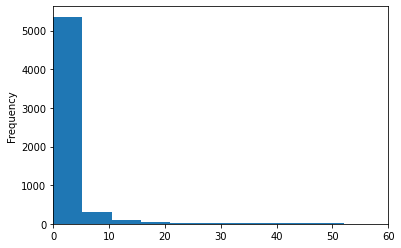

In [250]:
cate_dt.完成百分比.plot.hist(bins=400, xlim=[0, 60])

<AxesSubplot:ylabel='Frequency'>

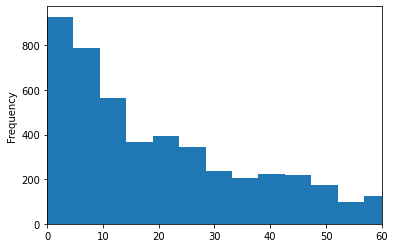

In [251]:
cate_dt.评论数量.plot.hist(bins=400, xlim=[0, 60])

<AxesSubplot:ylabel='Frequency'>

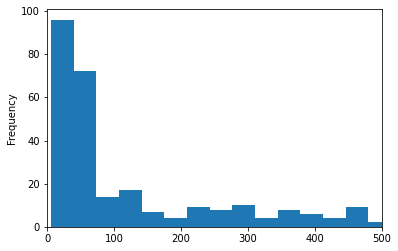

In [252]:
cate_dt[cate_dt.热门推荐 > 0].热门推荐.plot.hist(bins=50, xlim=[0, 500])

In [253]:
a_dt = dt[(dt.完成百分比 > 0) & (dt.完成百分比 < 20)]

In [254]:
cate_dt.各类版块总时长.describe()

count    5945.000000
mean      306.363436
std       549.407296
min     -1559.999369
25%         0.000000
50%         0.000000
75%       473.989722
max      4091.999722
Name: 各类版块总时长, dtype: float64

In [326]:
ratio_dict = {'is_即将上架': [], 'is_最新上架': [], 'is_各类版块总时长': [], 'is_热门推荐': [], 'is_即将结束': []}
for i in np.arange(0.5, 20, 0.5):
    for k in ratio_dict:
        x = cate_dt[cate_dt.完成百分比 >= i][k].value_counts().values
        ratio_dict[k].append(x[1]/np.sum(x))

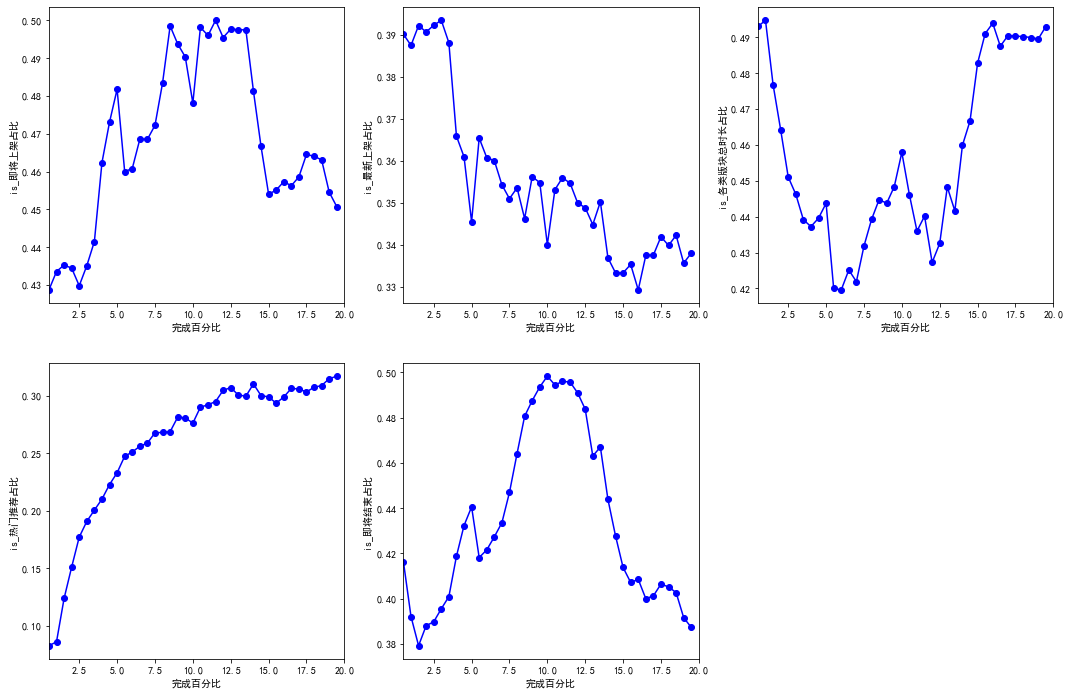

In [331]:
fig = plt.figure(figsize=[18, 12])
for i, k in enumerate(ratio_dict):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xlim([0.5, 20])
#     ax.set_ylim([0, 0.6])
    ax.plot(np.arange(0.5, 20, 0.5), ratio_dict[k], 'bo-')
    ax.set_xlabel(f'完成百分比')
    ax.set_ylabel(f'{k}占比')

In [332]:
cate_dt[demo_cols].describe()

,即将上架,最新上架,热门推荐,各类版块总时长,即将结束,is_即将上架,is_最新上架,is_热门推荐,is_各类版块总时长,is_即将结束
count,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000,5945.000000
mean,26.678692,57.209541,13.783753,306.363436,17.957700,0.631287,0.414971,0.055004,0.439193,0.415307
std,35.041308,155.486018,99.943594,549.407296,58.901761,0.482497,0.492758,0.228008,0.496330,0.492816
min,-150.400551,-17.995282,-47.999921,-1559.999369,-953.999469,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000278,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,41.999722,89.995833,0.000000,473.989722,42.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,353.999422,2082.000278,1698.000278,4091.999722,1044.000278,1.000000,1.000000,1.000000,1.000000,1.000000


In [333]:
cate_dt[cate_dt.各类版块总时长 < 0][demo_cols]  # 异常项目

,即将上架,最新上架,热门推荐,各类版块总时长,即将结束,is_即将上架,is_最新上架,is_热门推荐,is_各类版块总时长,is_即将结束
106102,0.000000,0.000000,0.0,-287.999948,0.000000,0,0,0,0,0
108282,0.000000,0.000000,0.0,-816.414354,0.000000,0,0,0,0,0
108913,0.000000,0.000000,0.0,-154.924392,0.000000,0,0,0,0,0
109261,0.000000,0.000000,0.0,-408.000337,0.000000,0,0,0,0,0
109484,0.000000,0.000000,0.0,-130.924495,0.000000,0,0,0,0,0
109935,0.000000,0.000000,0.0,-408.000292,-618.000285,0,0,0,0,0
120514,0.000000,0.000000,0.0,-12.000324,0.000000,0,0,0,0,0
1819819063,17.991944,12.000000,0.0,-17.999876,0.000000,1,1,0,0,0
1820167844,65.999509,12.000000,0.0,-24.000343,0.000000,1,1,0,0,0
1820692494,77.999735,0.000000,0.0,-24.000013,0.000000,1,0,0,0,0


In [257]:
item = f_project.find_one({"详细信息._id": '106596'}, 
                          projection={'详细信息.状态变换时间0-1': True, '详细信息.状态变换时间1-2': True, 
                                      '详细信息.状态变换时间2-3': True, '详细信息.状态变换时间3-4': True, 
                                      '详细信息.众筹期限': True})
# projection={'状态变换时间0-1': True, '状态变换时间1-2': True, '状态变换时间2-3': True, '状态变换时间3-4': True, '众筹期限': True}

In [258]:
item

{'_id': ObjectId('5c49922bd63a7505e5b54401'),
 '详细信息': {'状态变换时间0-1': datetime.datetime(2019, 1, 23, 12, 26, 39, 813000),
  '状态变换时间1-2': datetime.datetime(2019, 1, 24, 18, 0, 4, 35000),
  '众筹期限': 30}}

## 3. 回归分析

> 完成百分比大于0, 各版块时间大于0的样本数量:
> 
> 最新上架: 1356, 各类版块总时长: 1731, 热门推荐: 301, 即将结束: 2127

In [334]:
cate_dt[['即将上架', '最新上架', '各类版块总时长', '热门推荐', '即将结束']].corr()

,即将上架,最新上架,各类版块总时长,热门推荐,即将结束
即将上架,1.000000,0.162506,0.229384,0.009445,-0.021195
最新上架,0.162506,1.000000,0.341810,0.118279,0.143186
各类版块总时长,0.229384,0.341810,1.000000,0.365926,0.368724
热门推荐,0.009445,0.118279,0.365926,1.000000,0.214804
即将结束,-0.021195,0.143186,0.368724,0.214804,1.000000


- 成功项目

In [260]:
cate_dt[(cate_dt.完成百分比 >= 1) & (cate_dt.即将结束 > 0)].describe()

,众筹期限,目标金额,评论数量,档位数量,筹集金额,关注数,支持者数,点赞数,完成百分比,绝对时间跨度,...,类别_健康医疗,类别_健康生活,类别_公益,类别_原创设计,类别_品质家居,类别_数码周边,类别_文化传承,类别_智能家居,类别_车品,类别_食品
count,2127.000000,2127.000000,2122.000000,2127.000000,2.127000e+03,2127.000000,2127.000000,2127.000000,2127.000000,2.127000e+03,...,2127.000000,2127.000000,2127.000000,2127.00000,2127.000000,2127.000000,2127.000000,2127.000000,2127.000000,2127.000000
mean,37.647391,33430.094029,44.968897,1.285378,8.672570e+04,608.349788,660.058768,299.474847,7.124673,1.171379e+06,...,0.041373,0.050306,0.205924,0.16173,0.028679,0.043253,0.149976,0.037142,0.031970,0.228021
std,10.886819,45862.591904,60.574501,1.265687,1.851775e+05,1563.278212,1665.685016,943.167907,67.197384,1.114122e+06,...,0.199198,0.218626,0.404470,0.36829,0.166942,0.203475,0.357132,0.189153,0.175961,0.419655
min,10.000000,10.000000,0.000000,1.000000,1.421000e+03,6.000000,3.000000,0.000000,1.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,10000.000000,10.000000,1.000000,1.654100e+04,56.000000,82.000000,6.000000,1.140000,2.160055e+05,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,10000.000000,25.000000,1.000000,4.739400e+04,145.000000,181.000000,19.000000,1.750000,7.748500e+05,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,50000.000000,56.000000,1.000000,9.062400e+04,657.000000,447.500000,112.000000,3.345000,1.990823e+06,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,180.000000,1000000.000000,816.000000,14.000000,4.010531e+06,31909.000000,20494.000000,28972.000000,2087.000000,5.184000e+06,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [269]:
cate_dt[(cate_dt.完成百分比 > 1)][[*demo_cols, '关注数', '支持者数', '评论数量', '完成百分比']].describe()

,最新上架,热门推荐,各类版块总时长,即将结束,is_最新上架,is_热门推荐,is_各类版块总时长,is_即将结束,关注数,支持者数,评论数量,完成百分比
count,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3441.000000,3421.000000,3441.000000
mean,67.118931,23.563043,400.237070,34.231441,0.388550,0.087475,0.495786,0.608544,680.077303,788.630631,58.178018,7.022793
std,183.576242,130.419688,631.953487,66.919182,0.487491,0.282570,0.500055,0.488147,1517.807852,2034.887913,102.107853,57.317978
min,0.000000,0.000000,-1559.999369,-402.000757,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.010000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,97.000000,13.000000,1.140000
50%,0.000000,0.000000,0.000000,29.999722,0.000000,0.000000,0.000000,1.000000,184.000000,221.000000,30.000000,1.750000
75%,89.998333,0.000000,665.995833,48.000000,1.000000,0.000000,1.000000,1.000000,928.000000,588.000000,66.000000,3.500000
max,2082.000278,1698.000278,4091.999722,1044.000278,1.000000,1.000000,1.000000,1.000000,31909.000000,41008.000000,1893.000000,2087.000000


`(cate_dt.完成百分比 >= 1) & ((cate_dt.各类版块总时长 > 0) | (cate_dt.热门推荐 > 0) | (cate_dt.最新上架 > 0) | (cate_dt.即将结束 > 0))`

In [335]:
is_demo_cols = ['is_即将上架', 'is_最新上架', 'is_热门推荐', 'is_各类版块总时长', 'is_即将结束']

In [336]:
mod = smf.ols(formula='np.log(完成百分比)~关注数+支持者数+评论数量+np.log(目标金额)+' + '+'.join(cate_cols)+ '+' + '+'.join(is_demo_cols), 
              data=cate_dt[(cate_dt.完成百分比 > 1)])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(完成百分比)   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     102.7
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          5.42e-317
Time:                        11:12:03   Log-Likelihood:                -3882.9
No. Observations:                3421   AIC:                             7806.
Df Residuals:                    3401   BIC:                             7929.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3885      0.145     30.255      0.000       4.104       4.673
关注数            6.16e-05   1.03e-05      5.957      0.000    4.13e-05    8.19e-05
支持者数             0.0001   8.15e-06     12.959      0.000    8.96e-05       0.000
评论数量             0.0020      0.000     13.187      0.000       0.002       0.002
np.log(目标金额)    -0.3845      0.014    -27.137      0.000      -0.412      -0.357
类别_个人护理          0.4825      0.079      6.083      0.000       0.327       0.638
类别_健康医疗          0.5773      0.060      9.634      0.000       0.460       0.695
类别_健康生活          0.4483      0.066      6.818      0.000       0.319       0.577
类别_公益            0.2814      0.034      8.296      0.000       0.215       0.348
类别_原创设计          0.3625      0.032     11.311      0.000       0.300       0.425
类别_品质家居          0.2260      0.073      3.108      0.002       0.083       0.369
类别_数码周边          0.4087      0.058      7.025      0.000       0.295       0.523
类别_文化传承          0.4044      0.036     11.101      0.000       0.333       0.476
类别_智能家居          0.4875      0.054      8.992      0.000       0.381       0.594
类别_车品            0.3287      0.062      5.261      0.000       0.206       0.451
类别_食品            0.3813      0.032     11.748      0.000       0.318       0.445
is_即将上架         -0.2636      0.046     -5.782      0.000      -0.353      -0.174
is_最新上架         -0.0831      0.035     -2.376      0.018      -0.152      -0.015
is_热门推荐          0.5293      0.050     10.557      0.000       0.431       0.628
is_各类版块总时长       0.1898      0.036      5.307      0.000       0.120       0.260
is_即将结束         -0.2896      0.046     -6.304      0.000      -0.380      -0.200
==============================================================================
Omnibus:                      798.645   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3743.155
Skew:                           1.047   Prob(JB):                         0.00
Kurtosis:                       7.677   Cond. No.                     2.06e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.94e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- 失败项目

In [263]:
cate_dt[(cate_dt.完成百分比 < 1) & (cate_dt.完成百分比 > 0)][demo_cols].describe()

,最新上架,热门推荐,各类版块总时长,即将结束,is_最新上架,is_热门推荐,is_各类版块总时长,is_即将结束
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,44.742574,0.294540,180.245636,-5.385278,0.460909,0.010000,0.372727,0.139545
std,106.271166,4.290953,374.766644,33.493368,0.498583,0.099521,0.483640,0.346594
min,-17.995282,-47.999756,-816.414354,-953.999469,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,89.991944,0.000000,150.000213,0.000000,1.000000,0.000000,1.000000,0.000000
max,1332.000278,119.999973,2688.000518,66.000278,1.000000,1.000000,1.000000,1.000000


In [264]:
cate_dt[(cate_dt.完成百分比 < 1) & (cate_dt.完成百分比 > 0) & (cate_dt.热门推荐 > 0)]

,状态,众筹期限,公司名称,公司地址,公司工作时间,公司电话,发起人名称,发起人链接,所属类别,目标金额,...,类别_健康医疗,类别_健康生活,类别_公益,类别_原创设计,类别_品质家居,类别_数码周边,类别_文化传承,类别_智能家居,类别_车品,类别_食品
112860,众筹中,45,广州市立活龙智能设备有限公司,广东广州市番禺区 钟村汉溪路六横一4号103房,工作日 09:00-18:00,020-31147351,jd_133800cvv,/funderCenter.action?flag=2&id=112860,健康医疗,50000,...,1,0,0,0,0,0,0,0,0,0
113230,众筹中,45,醴陵御品坊瓷业有限公司,湖南株洲市醴陵市 玉瓷北路1号,工作日 09:00-19:00,400-883-0731,醴陵御品坊瓷,/funderCenter.action?flag=2&id=113230,文化传承,20000,...,0,0,0,0,0,0,1,0,0,0
113760,众筹中,30,上海汉仁红木家具有限公司,上海闵行区城区 涞亭北路705弄1号楼二楼2035 2046号,工作日 09:00-18:00,021-34307866,汉仁红木,/funderCenter.action?flag=2&id=113760,品质家居,100000,...,0,0,0,0,1,0,0,0,0,0
113928,众筹中,30,惠州市荣光五金电子有限公司,广东惠州市惠阳区 仲恺高新区陈江街道办事处罗群工业区内,工作日 09:00-18:00,13075211111,WingKwongCoffee,/funderCenter.action?flag=2&id=113928,健康生活,100000,...,0,1,0,0,0,0,0,0,0,0
119540,众筹中,20,北京国恒基业商贸有限公司,北京丰台区三环到四环之间 北京市丰台区南方庄一号院2号楼13层1309室,周一至周日 09:00-21:00,400-880-8787,ghjy006,/funderCenter.action?flag=2&id=119540,智能家居,100000,...,0,0,0,0,0,0,0,1,0,0
1818398864,众筹中,60,北京乐天地商贸有限责任公司,北京昌平区 北京市昌平区延寿镇黑山寨村(原黑山寨办事处)院内78号,工作日 09:00-21:00,13264091187,圭宝12345678,/funderCenter.action?flag=2&id=1818398864,原创设计,10000,...,0,0,0,1,0,0,0,0,0,0
1819819066,众筹中,60,中润普达（十堰）大数据中心有限公司,湖北十堰市 十堰市张湾区北京北路57号国瑞栖谷天街A区511号,工作日 09:00-18:00,400-852-9882,wuzhengai,/funderCenter.action?flag=2&id=1819819066,健康医疗,200000,...,1,0,0,0,0,0,0,0,0,0
1820485550,众筹中,60,山东脑放信息科技有限公司,广东深圳市宝安区 溪头工业园,工作日 10:00-19:00,400-678-1686,nfhifi,/funderCenter.action?flag=2&id=1820485550,数码周边,200000,...,0,0,0,0,0,1,0,0,0,0
1820892589,众筹中,60,重庆太菲堂网络科技有限公司,重庆渝北区城区 金石大道369号锦绣华城11幢29-2,周一至周日 09:00-23:00,15523470518,太菲堂网络科技,/funderCenter.action?flag=2&id=1820892589,原创设计,50000,...,0,0,0,1,0,0,0,0,0,0
1821184731,众筹中,45,浙江青田鸿祥进出口贸易有限公司,浙江丽水市 浙江省丽水市青田县油竹街道雅岙路167号,工作日 09:00-18:00,021-61320153,csr137*****837,/funderCenter.action?flag=2&id=1821184731,食品,50000,...,0,0,0,0,0,0,0,0,0,1


In [273]:
mod = smf.ols(formula='np.log(完成百分比)~关注数+支持者数+评论数量+np.log(目标金额)+' + '+'.join(cate_cols)+ '+' + '+'.join(is_demo_cols), 
              data=cate_dt[(cate_dt.完成百分比 < 1) & (cate_dt.完成百分比 > 0)])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(完成百分比)   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     25.18
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           2.46e-76
Time:                        11:36:12   Log-Likelihood:                -3230.1
No. Observations:                2138   AIC:                             6498.
Df Residuals:                    2119   BIC:                             6606.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1424      0.304      3.757      0.000       0.546       1.739
关注数          -1.264e-05   4.88e-05     -0.259      0.795      -0.000     8.3e-05
支持者数             0.0014      0.000     10.234      0.000       0.001       0.002
评论数量             0.0056      0.001      8.010      0.000       0.004       0.007
np.log(目标金额)    -0.3672      0.031    -11.887      0.000      -0.428      -0.307
类别_个人护理         -0.1639      0.102     -1.611      0.107      -0.363       0.036
类别_健康医疗         -0.0259      0.100     -0.258      0.796      -0.223       0.171
类别_健康生活          0.0468      0.121      0.387      0.699      -0.190       0.284
类别_公益            0.1058      0.076      1.390      0.165      -0.044       0.255
类别_原创设计          0.1563      0.061      2.543      0.011       0.036       0.277
类别_品质家居         -0.1292      0.113     -1.143      0.253      -0.351       0.093
类别_数码周边          0.1768      0.119      1.480      0.139      -0.057       0.411
类别_文化传承          0.3942      0.080      4.909      0.000       0.237       0.552
类别_智能家居          0.2764      0.091      3.021      0.003       0.097       0.456
类别_车品            0.3961      0.118      3.356      0.001       0.165       0.628
类别_食品           -0.0911      0.053     -1.722      0.085      -0.195       0.013
is_最新上架         -0.1583      0.052     -3.054      0.002      -0.260      -0.057
is_热门推荐         -0.1327      0.241     -0.550      0.582      -0.606       0.340
is_各类版块总时长       0.2459      0.053      4.646      0.000       0.142       0.350
is_即将结束          0.4556      0.071      6.406      0.000       0.316       0.595
==============================================================================
Omnibus:                       39.989   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.580
Skew:                          -0.105   Prob(JB):                     4.60e-06
Kurtosis:                       2.519   Cond. No.                     7.13e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.86e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [266]:
mod = smf.ols(formula='np.log(完成百分比)~关注数+支持者数+评论数量+np.log(目标金额)' + '+' + '+'.join(cate_cols), data=cate_dt[cate_dt.完成百分比 > 0])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(完成百分比)   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     123.0
Date:                Tue, 24 Aug 2021   Prob (F-statistic):          1.28e-312
Time:                        11:10:41   Log-Likelihood:                -10692.
No. Observations:                5617   AIC:                         2.141e+04
Df Residuals:                    5602   BIC:                         2.151e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.5331      0.222     15.914      0.000       3.098       3.968
关注数              0.0001   2.09e-05      5.252      0.000    6.88e-05       0.000
支持者数             0.0002   1.68e-05     13.668      0.000       0.000       0.000
评论数量             0.0052      0.000     17.217      0.000       0.005       0.006
np.log(目标金额)    -0.4514      0.023    -19.754      0.000      -0.496      -0.407
类别_个人护理         -0.2457      0.110     -2.241      0.025      -0.461      -0.031
类别_健康医疗          0.2334      0.094      2.474      0.013       0.048       0.418
类别_健康生活          0.3983      0.107      3.714      0.000       0.188       0.609
类别_公益            0.6172      0.060     10.356      0.000       0.500       0.734
类别_原创设计          0.3601      0.054      6.714      0.000       0.255       0.465
类别_品质家居         -0.0212      0.112     -0.189      0.850      -0.241       0.198
类别_数码周边          0.5002      0.100      5.010      0.000       0.305       0.696
类别_文化传承          0.7801      0.064     12.271      0.000       0.655       0.905
类别_智能家居          0.4620      0.087      5.339      0.000       0.292       0.632
类别_车品            0.3442      0.104      3.300      0.001       0.140       0.549
类别_食品            0.1046      0.050      2.080      0.038       0.006       0.203
==============================================================================
Omnibus:                      577.073   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              996.835
Skew:                          -0.715   Prob(JB):                    3.47e-217
Kurtosis:                       4.488   Cond. No.                     1.10e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.77e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""